In [1]:
import os
import numpy as np
from run_stages.pattern_generation_stage import Text, Grating, Rectangle, Circle, FullField, Subframe, Frame, ProjectionSequence

generate_pattern = True
intensity = 3
frequency = 30
duration = 9.8
grating_width = 120

# Landolt C
# subframes = [Subframe(duration_ms=duration, patterns=[Text(text='C')]),
#              Subframe(duration_ms=(1/frequency)*1E3-duration, patterns=[FullField('black')])]

# list_of_frames = [Frame(name="Landolt_C_PS100", repetitions=1, subframes=subframes)]
# list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=list_of_frames)]
# video_sequence_name = [f'Landolt_C_PS100_{frequency}Hz_2']
### Alternating grating
intensity = 3
frequency = 64
duration = (1/frequency)*1E3 / 4
grating_width = 120
first_grating = f'first_grating_{grating_width}um_{frequency}Hz_{intensity}mW_on_for_{duration}ms'
first_grating_subframes= [Subframe(duration_ms=duration, patterns=[Grating(position=(0, 0), rotation=0, unit='um', width_grating=grating_width, pitch_grating=grating_width)]),
            Subframe(duration_ms=duration, patterns=[Circle()]),
            Subframe(duration_ms=duration, patterns=[Text(text='C')]),
            Subframe(duration_ms=duration, patterns=[FullField('black')]),
]

duration = (1/frequency)*1E3 / 4

second_grating = f'second_grating_{grating_width}um_{frequency}Hz_{intensity}mW_on_for_{duration}ms'
second_grating_subframes= [Subframe(duration_ms=duration, patterns=[Grating(position=(grating_width, 0), rotation=0, unit='um', width_grating=grating_width, pitch_grating=grating_width)]),
            Subframe(duration_ms=duration, patterns=[Rectangle(rotation=100)]),
            Subframe(duration_ms=duration, patterns=[Text(text='A')]),
            Subframe(duration_ms=duration, patterns=[FullField('black')])]
frames = [Frame(name=first_grating, repetitions=32, subframes=first_grating_subframes)]
list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=frames)]
video_sequence_name = [f'alternating_gratings_{grating_width}um_4ms_on_switching_every_500ms']


## No multiplexing, 4 subframe (working version of buggy bipolar)

In [ ]:

configuration = {}
configuration['multiplexing'] = {'multiplex': False, 'num_split': 4, 'alg': 'horizontal'} 
# geometry-defined configuration
configuration["model"]                            = "bipolar"     # model geometry: monopolar or bipolar
configuration["pixel_size"]                       = 100           # pixel size
configuration["pixel_size_suffix"]                = "-lg"         # If large format is required, use "-lg", else use ""
configuration["frame_width"]                      = 1000       # implant radius in mm
configuration["geometry"]                         = "Flat_human"  # geometry settings: HC/Pillar/Flat devices in
# pdish/rat/human
configuration["number_of_diodes"]                 = 2             # number of photo diodes per pixel
configuration["sirof_capacitance"]                = 6             # SIROF capacitance in mF/cm^2
configuration["photosensitive_area_edge_to_edge"] = 92           # edge-to-edge size of the photosensitive area
configuration["active_electrode_radius"]          = 17            # radius of the active electrode in um
configuration["light_to_current_conversion_rate"] = 0.4           # light to current conversion rate in A/W
configuration["photosensitive_area"]              = 4075.72       # total photosensitive area in um^2. Assign "None" for
# auto calculation (only works for monopolar)

# R matrix parameters
configuration["r_matrix_output_file"]             = f'R_{configuration["geometry"]}_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl' 
configuration["r_matrix_conductivity"]            = 1             # conductivity scaling factor of the electrolyte

# dynamic simulation configuration
configuration["Ipho_scaling"]                     = 1  # artificial scaling of photo current, useful for
                                                     # parametric sweep (e.g. S-D curve)
configuration["Isat"]                             = 0.02          # diode saturation current in pA
configuration["ideality_factor"]                  = 1.14          # ideality factor n of the diode
configuration["shunt_resistance"]                 = 790150.0     # shunt resistance in Ohm. Assign "None" if no
# shunt
configuration["initial_Vactive"]                  = 0          # Initial bias of the active electrode in V
configuration["temperature"]                      = 37
configuration["nominal_temperature"]              = 25
# TODO make sure that the duration is sufficiently long compared to the frequencz, i.e. at least 6 times the period
configuration["simulation_duration_sec"]          = 1/frequency * 15             # simulation duration in seconds
configuration["simulation_resolution_ms"]         = None          # None defaults to Xyce inner value

# input paths
configuration["user_files_path"]                  = None          # If set to None, defaults to inner user_files directory
configuration["pixel_label_input_file"]           = f'image_sequence/pixel_label_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl'

#### Projection sequences related ####

configuration["video_sequence_name"]              = video_sequence_name
configuration["pattern_generation"]               = {"generate_pattern": generate_pattern}
if generate_pattern:
    tmp = \
        {
        "projection_sequences"              : list_projections,
        "font_path"                         : None, # If set to None for, defaults to optometrist font Sloan.otf
        "projection_sequences_stored_config" : None # Used for storing the config, but part of the skipped parameters
        }
    configuration["pattern_generation"].update(tmp)

# define input files for monopolar arrays
configuration["monopolar"] = \
    {
    "return_to_active_area_ratio": 5.7525,              # ratio between return area and total active area 
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_EP_return_2D": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_return_2D-whole.csv',
    "r_matrix_input_file_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_self.csv', # used for resistive mesh only
    "r_matrix_input_file_non_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_Rmat.csv' # used for resistive mesh only
    }

# define input files for bipolar arrays
bipolar_dict = \
    {
    "additional_edges": 142,                                     # bipolar only: edge segments of the return
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_return": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return.csv',
    "r_matrix_input_file_return_neighbor": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_neighbor.csv', # used for resistive mesh only
    }
if configuration["model"] == 'bipolar': # Special file existing only for the bipolar PS100 and PS75 configurations
        bipolar_dict["r_matrix_input_file_return_near"] = f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_near.csv'

configuration["bipolar"] = bipolar_dict

# post-process parameters
configuration["post_process"] = \
    {
    "pulse_start_time_in_ms": (1/frequency)*1e3 * 6, # Set to 200 ms if frequency is not defined
    "pulse_duration_in_ms": 9.8,
    # Related to the time dynamics analyzis
    "average_over_pulse_duration": True,
    "pulse_extra_ms": 0,
    "time_averaging_resolution_ms": 1,
    "interpolation_resolution_ms": 1e-3,
    # For improving computations speed, warning it may crash for sume configurations!
    "multiprocessing": False,
    "cpu_to_use": None, # If set to None, automatically uses 2/3 of the cpu available
    # Related to spatial analyzis 
    "depth_values_in_um": None, # if None, defaults to all available in model otherwise use list of list: [[0,1,5,50,155]]
    "on_diode_threshold_mV": 50
    }

configuration["plot_results"] = \
    {
    "plot_time_windwow_start_ms": 200.0, # If set to None, selects the post proces stage values
    "plot_time_window_end_ms": 209.8,
    "plot_potential_depth_um": 60
    }

### EXECUTION
from RPSim import run_rpsim
# Stages name: "pattern_generation" - "resistive_mesh" - "current_sequence" - "circuit" - "simulation" - "post_process" - "plot_results"
run_stages = [ "pattern_generation", "resistive_mesh", "current_sequence", "circuit", "simulation", 'post_process', 'plot_results']
run_rpsim(configuration=configuration, run_stages=run_stages)#, skip_stages="post_process")

## Result of modified code

[2024-08-08 13:28:00] INFO       run_rpsim        Staring a new run
[2024-08-08 13:28:00] INFO       run_rpsim        Output directory: /Users/vision/Desktop/RPSim/user_files/user_output/13_28_00-2024_08_08
[2024-08-08 13:28:00] INFO       run_rpsim        Requested run stages: ['pattern_generation', 'resistive_mesh', 'current_sequence', 'circuit', 'simulation', 'post_process', 'plot_results']
[2024-08-08 13:28:00] INFO       run_rpsim        Running the following configuration
====>User Inputs
+--------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
| Field                          | Value                                                                                                                                      |
+--------------------------------+------------------------------------------------------------------------------------------------------------------

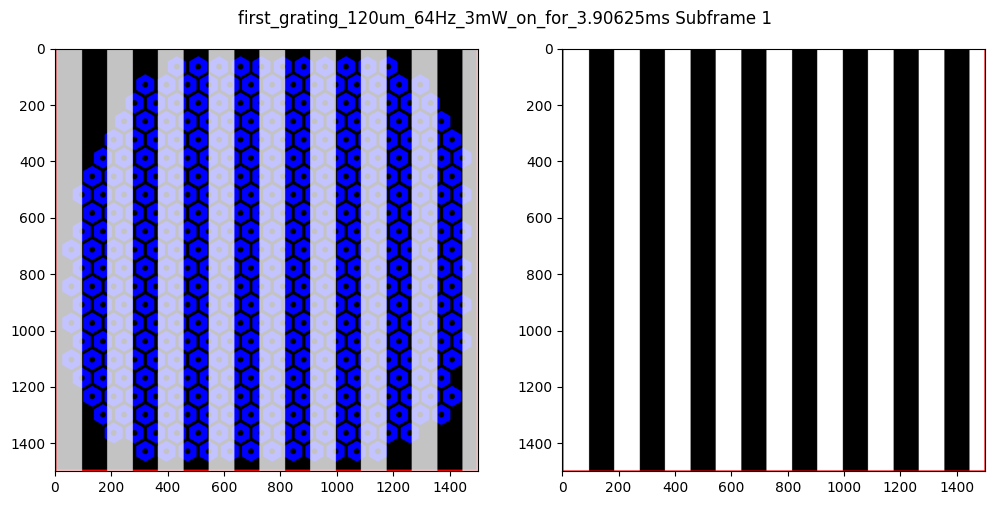

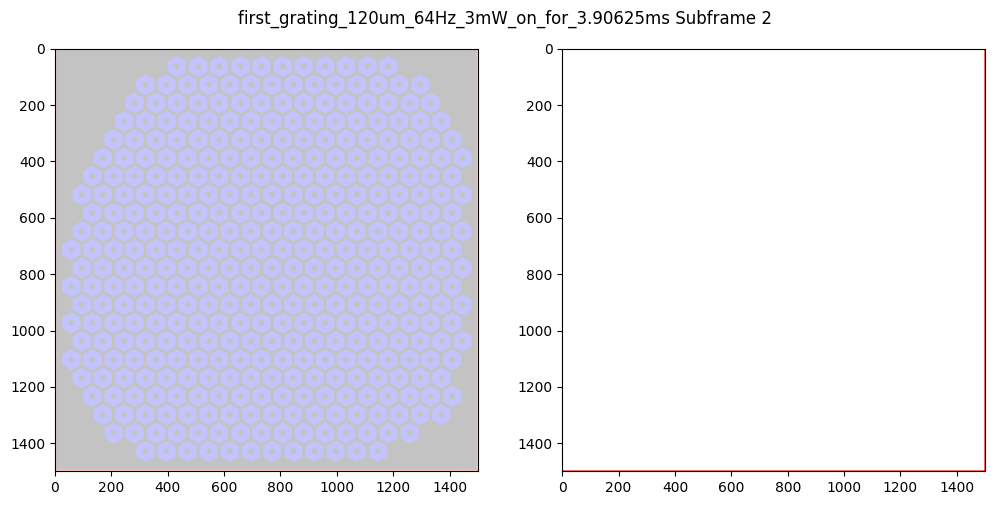

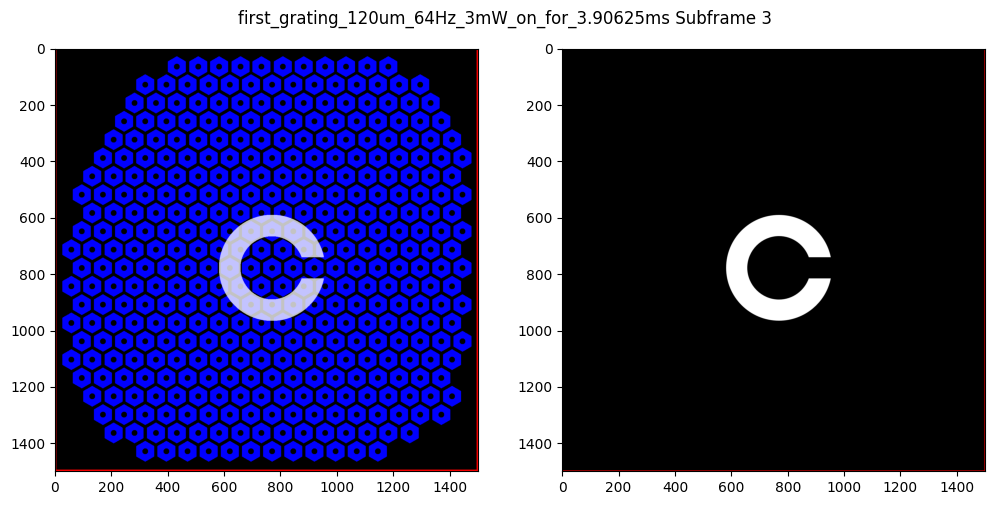

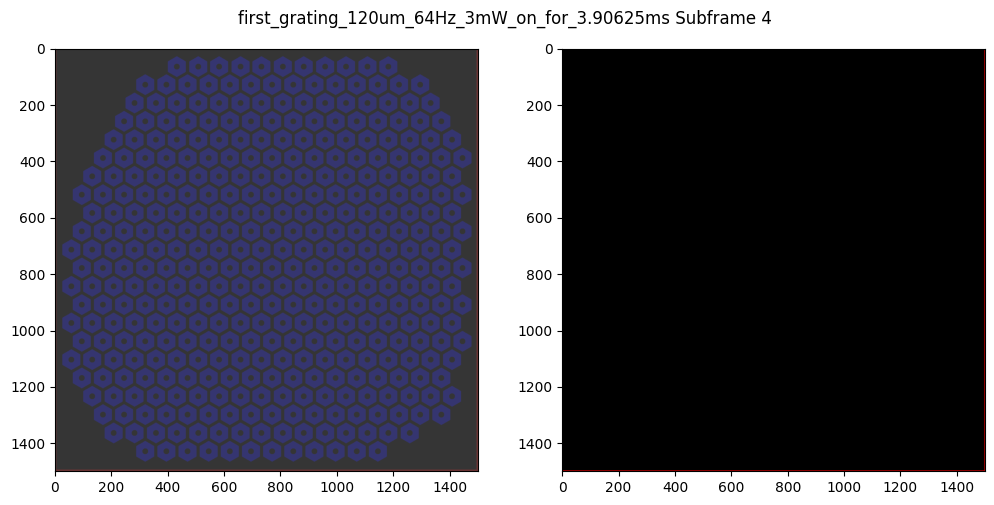

[2024-08-08 13:28:11] INFO       run_rpsim        Running Resistive_Mesh Stage
[2024-08-08 13:28:12] INFO       run_rpsim        Running Current_Sequence Stage


4
[3.90625, 3.90625, 3.90625, 3.90625]
(1, 4)
(756, 1, 4)
378
(756, 1, 4)
[[0.       2.445432 0.       0.      ]]


[2024-08-08 13:28:39] INFO       run_rpsim        Running Circuit Stage
[2024-08-08 13:28:48] INFO       run_rpsim        Running Simulation Stage

Netlist warning: No print specified
[2024-08-08 13:34:09] INFO       run_rpsim        Running Post_Process Stage


Processing Z-slice: 160 of time point 1/1: 100%|██████████| 160/160 [32:26<00:00, 12.16s/it]


[2024-08-08 14:06:51] INFO       run_rpsim        Running Plot_Results Stage
[2024-08-08 14:06:54] INFO       run_rpsim        Finished running all provided configurations
[2024-08-08 14:06:54] INFO       run_rpsim        Execution time is 38.90 minutes


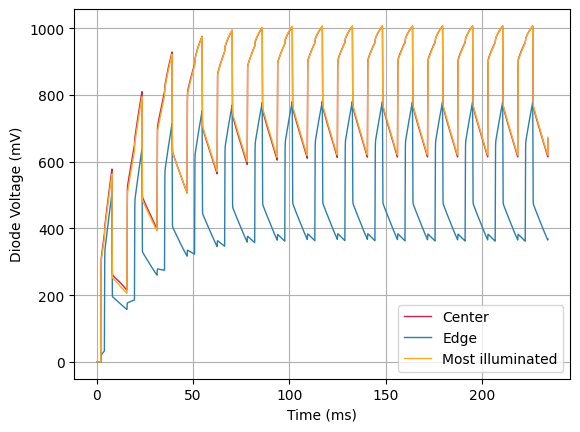

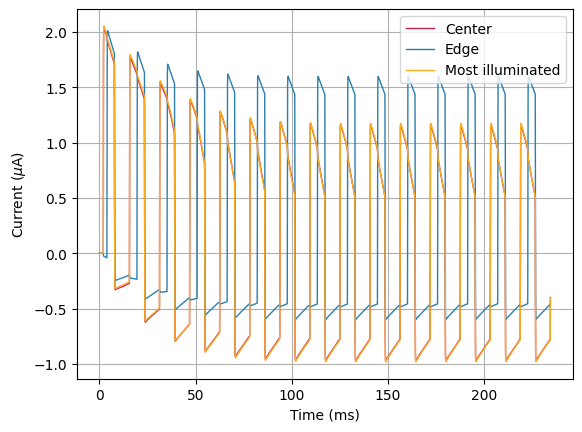

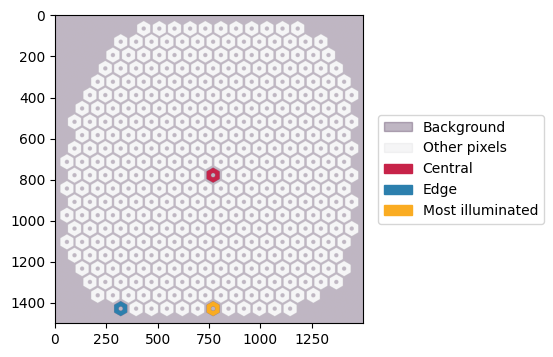

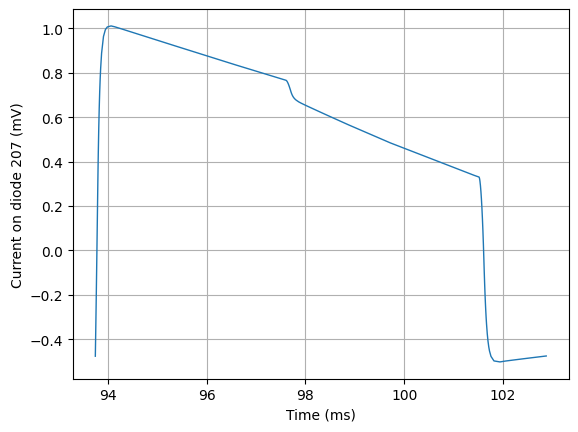

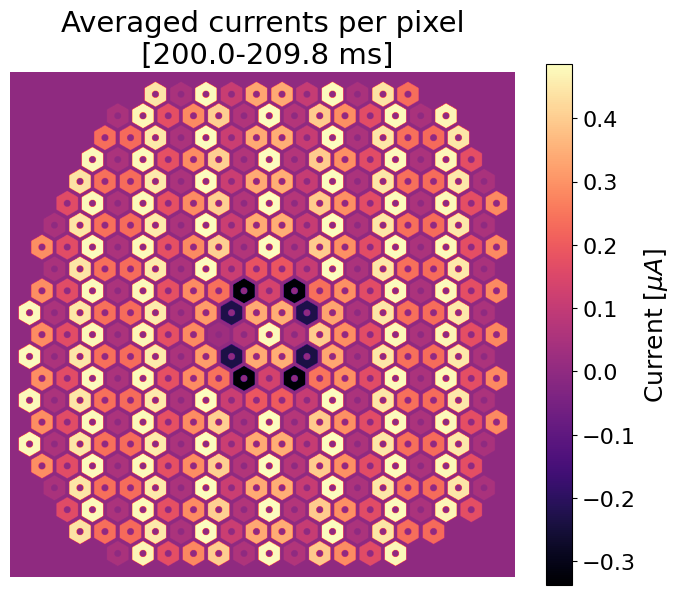

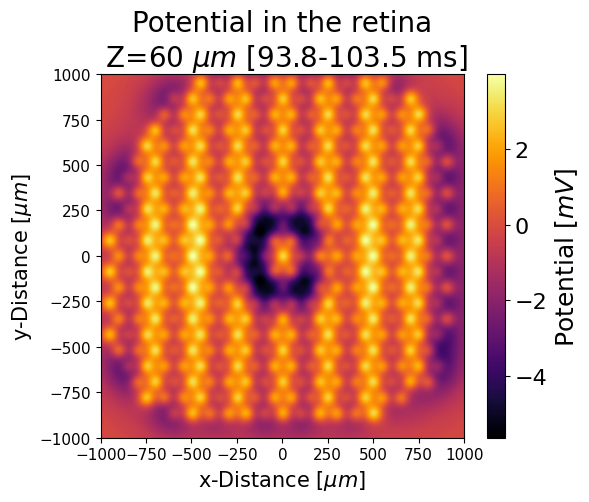

In [2]:
import os
import numpy as np
from run_stages.pattern_generation_stage import Text, Grating, Rectangle, Circle, FullField, Subframe, Frame, ProjectionSequence

generate_pattern = True
intensity = 3
frequency = 30
duration = 9.8
grating_width = 120

# Landolt C
# subframes = [Subframe(duration_ms=duration, patterns=[Text(text='C')]),
#              Subframe(duration_ms=(1/frequency)*1E3-duration, patterns=[FullField('black')])]

# list_of_frames = [Frame(name="Landolt_C_PS100", repetitions=1, subframes=subframes)]
# list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=list_of_frames)]
# video_sequence_name = [f'Landolt_C_PS100_{frequency}Hz_2']
### Alternating grating
intensity = 3
frequency = 64
duration = (1/frequency)*1E3 / 4
grating_width = 120
first_grating = f'first_grating_{grating_width}um_{frequency}Hz_{intensity}mW_on_for_{duration}ms'
first_grating_subframes= [Subframe(duration_ms=duration, patterns=[Grating(position=(0, 0), rotation=0, unit='um', width_grating=grating_width, pitch_grating=grating_width)]),
            Subframe(duration_ms=duration, patterns=[Circle()]),
            Subframe(duration_ms=duration, patterns=[Text(text='C')]),
            Subframe(duration_ms=duration, patterns=[FullField('black')]),
]

duration = (1/frequency)*1E3 / 4

second_grating = f'second_grating_{grating_width}um_{frequency}Hz_{intensity}mW_on_for_{duration}ms'
second_grating_subframes= [Subframe(duration_ms=duration, patterns=[Grating(position=(grating_width, 0), rotation=0, unit='um', width_grating=grating_width, pitch_grating=grating_width)]),
            Subframe(duration_ms=duration, patterns=[Rectangle(rotation=100)]),
            Subframe(duration_ms=duration, patterns=[Text(text='A')]),
            Subframe(duration_ms=duration, patterns=[FullField('black')])]
frames = [Frame(name=first_grating, repetitions=32, subframes=first_grating_subframes)]
list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=frames)]
video_sequence_name = [f'alternating_gratings_{grating_width}um_4ms_on_switching_every_500ms']


configuration = {}
configuration['multiplexing'] = {'multiplex': False, 'num_split': 4, 'alg': 'horizontal'} 
# geometry-defined configuration
configuration["model"]                            = "bipolar"     # model geometry: monopolar or bipolar
configuration["pixel_size"]                       = 100           # pixel size
configuration["pixel_size_suffix"]                = "-lg"         # If large format is required, use "-lg", else use ""
configuration["frame_width"]                      = 1000       # implant radius in mm
configuration["geometry"]                         = "Flat_human"  # geometry settings: HC/Pillar/Flat devices in
# pdish/rat/human
configuration["number_of_diodes"]                 = 2             # number of photo diodes per pixel
configuration["sirof_capacitance"]                = 6             # SIROF capacitance in mF/cm^2
configuration["photosensitive_area_edge_to_edge"] = 92           # edge-to-edge size of the photosensitive area
configuration["active_electrode_radius"]          = 17            # radius of the active electrode in um
configuration["light_to_current_conversion_rate"] = 0.4           # light to current conversion rate in A/W
configuration["photosensitive_area"]              = 4075.72       # total photosensitive area in um^2. Assign "None" for
# auto calculation (only works for monopolar)

# R matrix parameters
configuration["r_matrix_output_file"]             = f'R_{configuration["geometry"]}_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl' 
configuration["r_matrix_conductivity"]            = 1             # conductivity scaling factor of the electrolyte

# dynamic simulation configuration
configuration["Ipho_scaling"]                     = 1  # artificial scaling of photo current, useful for
                                                     # parametric sweep (e.g. S-D curve)
configuration["Isat"]                             = 0.02          # diode saturation current in pA
configuration["ideality_factor"]                  = 1.14          # ideality factor n of the diode
configuration["shunt_resistance"]                 = 790150.0     # shunt resistance in Ohm. Assign "None" if no
# shunt
configuration["initial_Vactive"]                  = 0          # Initial bias of the active electrode in V
configuration["temperature"]                      = 37
configuration["nominal_temperature"]              = 25
# TODO make sure that the duration is sufficiently long compared to the frequencz, i.e. at least 6 times the period
configuration["simulation_duration_sec"]          = 1/frequency * 15             # simulation duration in seconds
configuration["simulation_resolution_ms"]         = None          # None defaults to Xyce inner value

# input paths
configuration["user_files_path"]                  = None          # If set to None, defaults to inner user_files directory
configuration["pixel_label_input_file"]           = f'image_sequence/pixel_label_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl'

#### Projection sequences related ####

configuration["video_sequence_name"]              = video_sequence_name
configuration["pattern_generation"]               = {"generate_pattern": generate_pattern}
if generate_pattern:
    tmp = \
        {
        "projection_sequences"              : list_projections,
        "font_path"                         : None, # If set to None for, defaults to optometrist font Sloan.otf
        "projection_sequences_stored_config" : None # Used for storing the config, but part of the skipped parameters
        }
    configuration["pattern_generation"].update(tmp)

# define input files for monopolar arrays
configuration["monopolar"] = \
    {
    "return_to_active_area_ratio": 5.7525,              # ratio between return area and total active area 
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_EP_return_2D": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_return_2D-whole.csv',
    "r_matrix_input_file_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_self.csv', # used for resistive mesh only
    "r_matrix_input_file_non_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_Rmat.csv' # used for resistive mesh only
    }

# define input files for bipolar arrays
bipolar_dict = \
    {
    "additional_edges": 142,                                     # bipolar only: edge segments of the return
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_return": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return.csv',
    "r_matrix_input_file_return_neighbor": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_neighbor.csv', # used for resistive mesh only
    }
if configuration["model"] == 'bipolar': # Special file existing only for the bipolar PS100 and PS75 configurations
        bipolar_dict["r_matrix_input_file_return_near"] = f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_near.csv'

configuration["bipolar"] = bipolar_dict

# post-process parameters
configuration["post_process"] = \
    {
    "pulse_start_time_in_ms": (1/frequency)*1e3 * 6, # Set to 200 ms if frequency is not defined
    "pulse_duration_in_ms": 9.8,
    # Related to the time dynamics analyzis
    "average_over_pulse_duration": True,
    "pulse_extra_ms": 0,
    "time_averaging_resolution_ms": 1,
    "interpolation_resolution_ms": 1e-3,
    # For improving computations speed, warning it may crash for sume configurations!
    "multiprocessing": False,
    "cpu_to_use": None, # If set to None, automatically uses 2/3 of the cpu available
    # Related to spatial analyzis 
    "depth_values_in_um": None, # if None, defaults to all available in model otherwise use list of list: [[0,1,5,50,155]]
    "on_diode_threshold_mV": 50
    }

configuration["plot_results"] = \
    {
    "plot_time_windwow_start_ms": 200.0, # If set to None, selects the post proces stage values
    "plot_time_window_end_ms": 209.8,
    "plot_potential_depth_um": 60
    }

### EXECUTION
from RPSim import run_rpsim
# Stages name: "pattern_generation" - "resistive_mesh" - "current_sequence" - "circuit" - "simulation" - "post_process" - "plot_results"
run_stages = [ "pattern_generation", "resistive_mesh", "current_sequence", "circuit", "simulation", 'post_process', 'plot_results']
run_rpsim(configuration=configuration, run_stages=run_stages)#, skip_stages="post_process")

## Buggy working version with multiplexing (4+2)

In [ ]:
import os
import numpy as np
from run_stages.pattern_generation_stage import Text, Grating, Rectangle, Circle, FullField, Subframe, Frame, ProjectionSequence

generate_pattern = True
intensity = 3
frequency = 30
duration = 9.8
grating_width = 120

# Landolt C
# subframes = [Subframe(duration_ms=duration, patterns=[Text(text='C')]),
#              Subframe(duration_ms=(1/frequency)*1E3-duration, patterns=[FullField('black')])]

# list_of_frames = [Frame(name="Landolt_C_PS100", repetitions=1, subframes=subframes)]
# list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=list_of_frames)]
# video_sequence_name = [f'Landolt_C_PS100_{frequency}Hz_2']
### Alternating grating
intensity = 3
frequency = 64
duration = (1/frequency)*1E3 / 3
grating_width = 120
first_grating = f'first_grating_{grating_width}um_{frequency}Hz_{intensity}mW_on_for_{duration}ms'
first_grating_subframes= [Subframe(duration_ms=duration, patterns=[Grating(position=(0, 0), rotation=0, unit='um', width_grating=grating_width, pitch_grating=grating_width)]),
            Subframe(duration_ms=duration, patterns=[FullField('black')]),
            Subframe(duration_ms=duration, patterns=[FullField('black')]),
]


frames = [Frame(name=first_grating, repetitions=32, subframes=first_grating_subframes)]
list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=frames)]
video_sequence_name = [f'alternating_gratings_{grating_width}um_4ms_on_switching_every_500ms']


configuration = {}
configuration['multiplexing'] = {'multiplex': False, 'num_split': 4, 'alg': 'horizontal'} 
# geometry-defined configuration
configuration["model"]                            = "bipolar"     # model geometry: monopolar or bipolar
configuration["pixel_size"]                       = 100           # pixel size
configuration["pixel_size_suffix"]                = "-lg"         # If large format is required, use "-lg", else use ""
configuration["frame_width"]                      = 1000       # implant radius in mm
configuration["geometry"]                         = "Flat_human"  # geometry settings: HC/Pillar/Flat devices in
# pdish/rat/human
configuration["number_of_diodes"]                 = 2             # number of photo diodes per pixel
configuration["sirof_capacitance"]                = 6             # SIROF capacitance in mF/cm^2
configuration["photosensitive_area_edge_to_edge"] = 92           # edge-to-edge size of the photosensitive area
configuration["active_electrode_radius"]          = 17            # radius of the active electrode in um
configuration["light_to_current_conversion_rate"] = 0.4           # light to current conversion rate in A/W
configuration["photosensitive_area"]              = 4075.72       # total photosensitive area in um^2. Assign "None" for
# auto calculation (only works for monopolar)

# R matrix parameters
configuration["r_matrix_output_file"]             = f'R_{configuration["geometry"]}_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl' 
configuration["r_matrix_conductivity"]            = 1             # conductivity scaling factor of the electrolyte

# dynamic simulation configuration
configuration["Ipho_scaling"]                     = 1  # artificial scaling of photo current, useful for
                                                     # parametric sweep (e.g. S-D curve)
configuration["Isat"]                             = 0.02          # diode saturation current in pA
configuration["ideality_factor"]                  = 1.14          # ideality factor n of the diode
configuration["shunt_resistance"]                 = 790150.0     # shunt resistance in Ohm. Assign "None" if no
# shunt
configuration["initial_Vactive"]                  = 0          # Initial bias of the active electrode in V
configuration["temperature"]                      = 37
configuration["nominal_temperature"]              = 25
# TODO make sure that the duration is sufficiently long compared to the frequencz, i.e. at least 6 times the period
configuration["simulation_duration_sec"]          = 1/frequency * 15             # simulation duration in seconds
configuration["simulation_resolution_ms"]         = None          # None defaults to Xyce inner value

# input paths
configuration["user_files_path"]                  = None          # If set to None, defaults to inner user_files directory
configuration["pixel_label_input_file"]           = f'image_sequence/pixel_label_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl'

#### Projection sequences related ####

configuration["video_sequence_name"]              = video_sequence_name
configuration["pattern_generation"]               = {"generate_pattern": generate_pattern}
if generate_pattern:
    tmp = \
        {
        "projection_sequences"              : list_projections,
        "font_path"                         : None, # If set to None for, defaults to optometrist font Sloan.otf
        "projection_sequences_stored_config" : None # Used for storing the config, but part of the skipped parameters
        }
    configuration["pattern_generation"].update(tmp)

# define input files for monopolar arrays
configuration["monopolar"] = \
    {
    "return_to_active_area_ratio": 5.7525,              # ratio between return area and total active area 
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_EP_return_2D": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_return_2D-whole.csv',
    "r_matrix_input_file_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_self.csv', # used for resistive mesh only
    "r_matrix_input_file_non_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_Rmat.csv' # used for resistive mesh only
    }

# define input files for bipolar arrays
bipolar_dict = \
    {
    "additional_edges": 142,                                     # bipolar only: edge segments of the return
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_return": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return.csv',
    "r_matrix_input_file_return_neighbor": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_neighbor.csv', # used for resistive mesh only
    }
if configuration["model"] == 'bipolar': # Special file existing only for the bipolar PS100 and PS75 configurations
        bipolar_dict["r_matrix_input_file_return_near"] = f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_near.csv'

configuration["bipolar"] = bipolar_dict

# post-process parameters
configuration["post_process"] = \
    {
    "pulse_start_time_in_ms": (1/frequency)*1e3 * 6, # Set to 200 ms if frequency is not defined
    "pulse_duration_in_ms": 9.8,
    # Related to the time dynamics analyzis
    "average_over_pulse_duration": True,
    "pulse_extra_ms": 0,
    "time_averaging_resolution_ms": 1,
    "interpolation_resolution_ms": 1e-3,
    # For improving computations speed, warning it may crash for sume configurations!
    "multiprocessing": False,
    "cpu_to_use": None, # If set to None, automatically uses 2/3 of the cpu available
    # Related to spatial analyzis 
    "depth_values_in_um": None, # if None, defaults to all available in model otherwise use list of list: [[0,1,5,50,155]]
    "on_diode_threshold_mV": 50
    }

configuration["plot_results"] = \
    {
    "plot_time_windwow_start_ms": 200.0, # If set to None, selects the post proces stage values
    "plot_time_window_end_ms": 209.8,
    "plot_potential_depth_um": 60
    }

### EXECUTION
from RPSim import run_rpsim
# Stages name: "pattern_generation" - "resistive_mesh" - "current_sequence" - "circuit" - "simulation" - "post_process" - "plot_results"
run_stages = [ "pattern_generation", "resistive_mesh", "current_sequence", "circuit", "simulation", 'post_process', 'plot_results']
run_rpsim(configuration=configuration, run_stages=run_stages)#, skip_stages="post_process")

## Modified Version with Multiplexing (4+2)

[2024-08-08 14:09:08] INFO       run_rpsim        Staring a new run
[2024-08-08 14:09:08] INFO       run_rpsim        Output directory: /Users/vision/Desktop/RPSim/user_files/user_output/14_09_08-2024_08_08
[2024-08-08 14:09:08] INFO       run_rpsim        Requested run stages: ['pattern_generation', 'multiplexing', 'resistive_mesh', 'current_sequence', 'circuit', 'simulation', 'post_process', 'plot_results']
[2024-08-08 14:09:08] INFO       run_rpsim        Running the following configuration
====>User Inputs
+--------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
| Field                          | Value                                                                                                                                      |
+--------------------------------+--------------------------------------------------------------------------------------------------

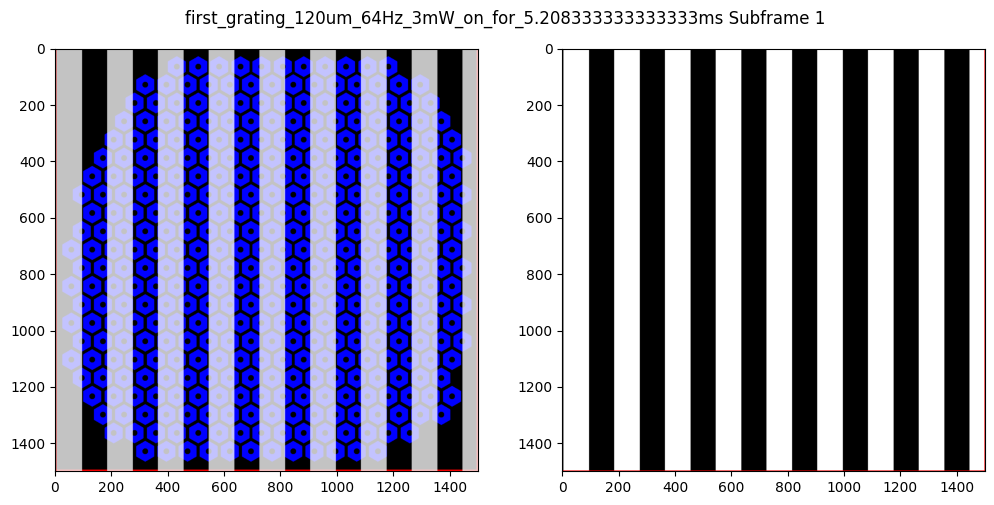

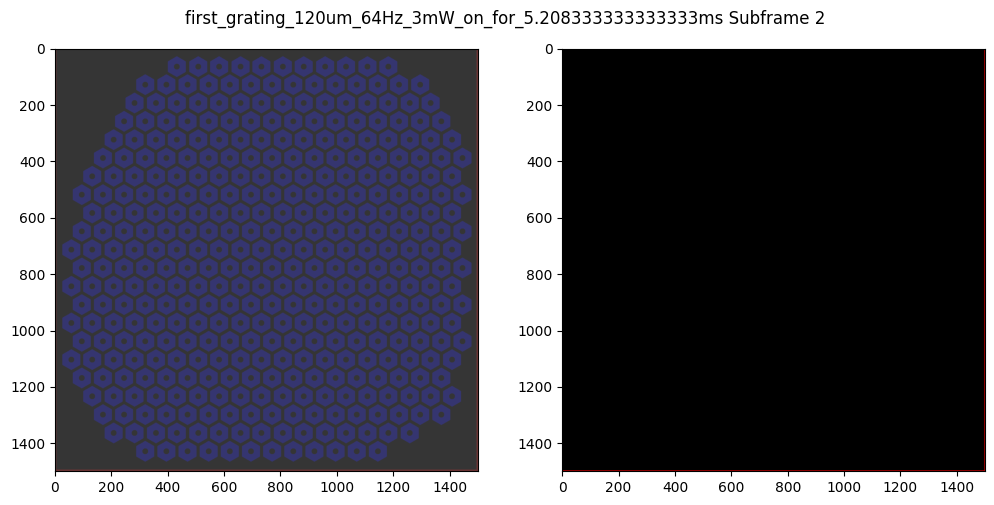

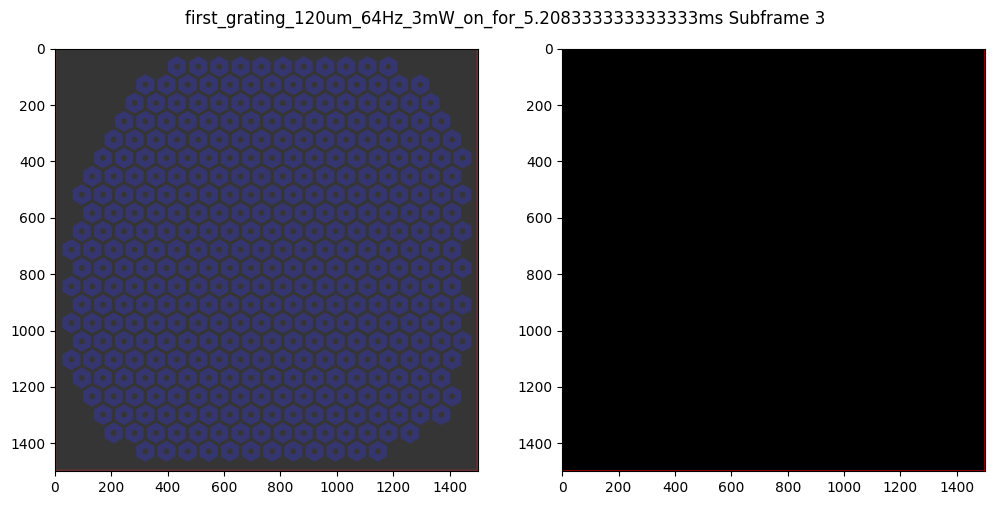

[2024-08-08 14:09:13] INFO       run_rpsim        Running Multiplexing Stage


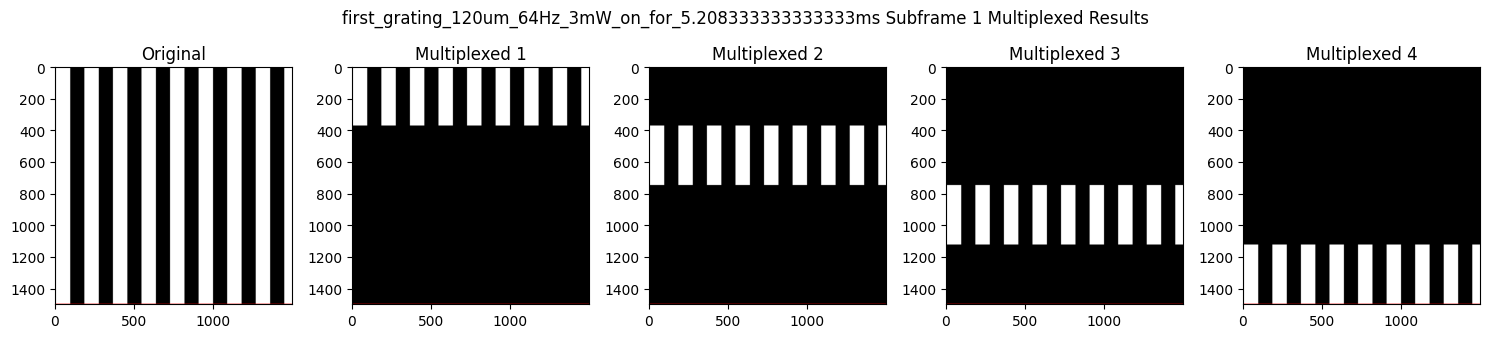

[2024-08-08 14:09:15] INFO       run_rpsim        Running Resistive_Mesh Stage
[2024-08-08 14:09:16] INFO       run_rpsim        Running Current_Sequence Stage


6
[1.3020833333333333, 1.3020833333333333, 1.3020833333333333, 1.3020833333333333, 5.208333333333333, 5.208333333333333]
(1, 6)
(756, 1, 6)
378
(756, 1, 6)
[[0. 0. 0. 0. 0. 0.]]


[2024-08-08 14:10:01] INFO       run_rpsim        Running Circuit Stage
[2024-08-08 14:10:11] INFO       run_rpsim        Running Simulation Stage

Netlist warning: No print specified
[2024-08-08 14:15:26] INFO       run_rpsim        Running Post_Process Stage


Processing Z-slice: 160 of time point 1/1: 100%|██████████| 160/160 [32:26<00:00, 12.17s/it]


[2024-08-08 14:48:08] INFO       run_rpsim        Running Plot_Results Stage
[2024-08-08 14:48:11] INFO       run_rpsim        Finished running all provided configurations
[2024-08-08 14:48:11] INFO       run_rpsim        Execution time is 39.04 minutes


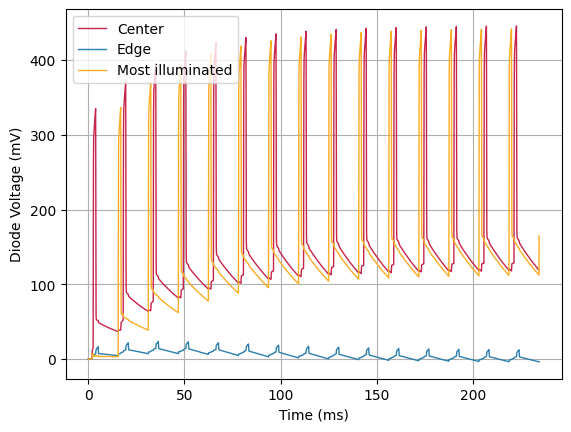

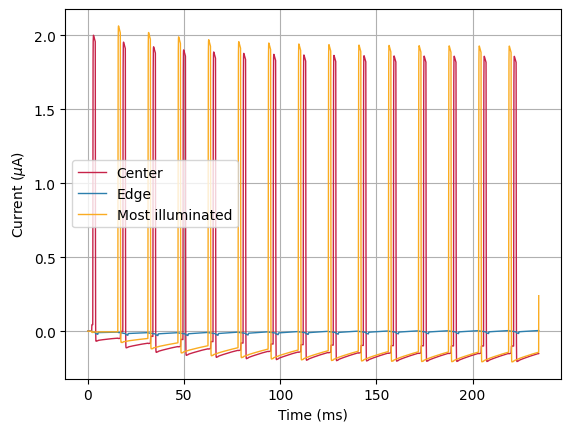

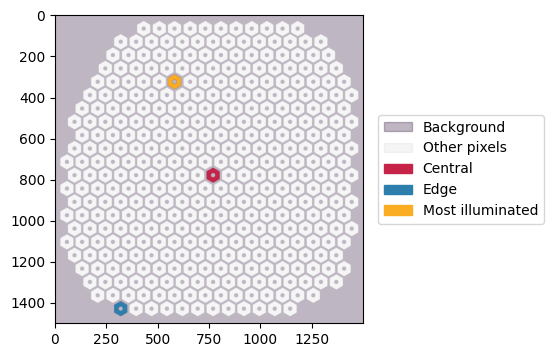

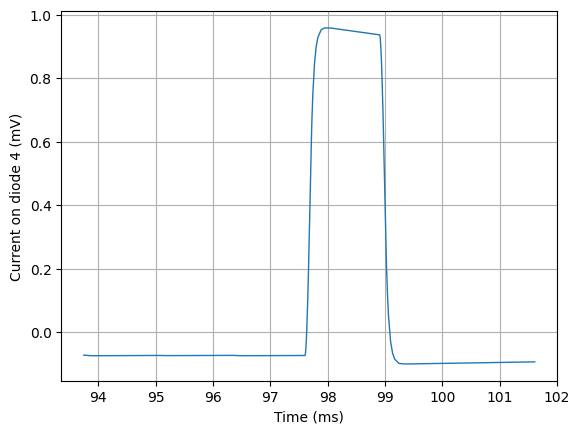

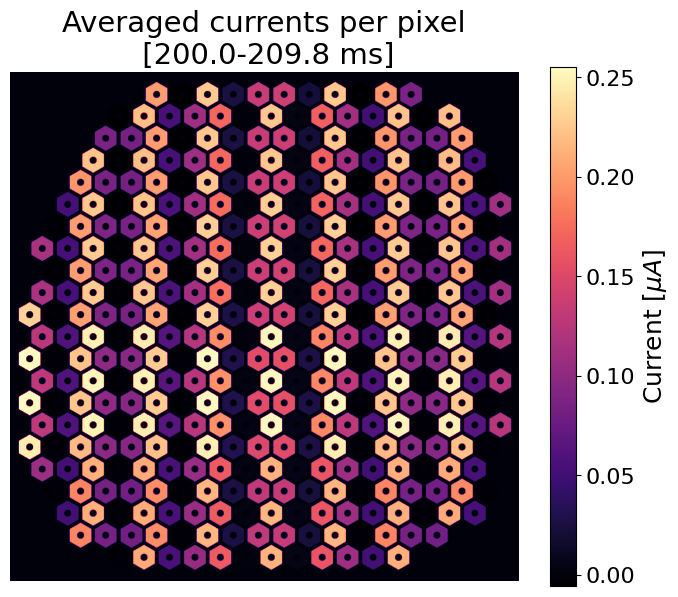

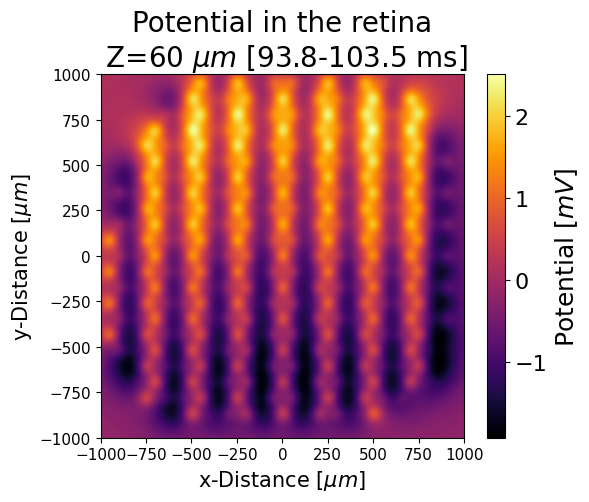

In [1]:
import os
import numpy as np
from run_stages.pattern_generation_stage import Text, Grating, Rectangle, Circle, FullField, Subframe, Frame, ProjectionSequence

generate_pattern = True
intensity = 3
frequency = 30
duration = 9.8
grating_width = 120

# Landolt C
# subframes = [Subframe(duration_ms=duration, patterns=[Text(text='C')]),
#              Subframe(duration_ms=(1/frequency)*1E3-duration, patterns=[FullField('black')])]

# list_of_frames = [Frame(name="Landolt_C_PS100", repetitions=1, subframes=subframes)]
# list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=list_of_frames)]
# video_sequence_name = [f'Landolt_C_PS100_{frequency}Hz_2']
### Alternating grating
intensity = 3
frequency = 64
duration = (1/frequency)*1E3 / 3
grating_width = 120
first_grating = f'first_grating_{grating_width}um_{frequency}Hz_{intensity}mW_on_for_{duration}ms'
first_grating_subframes= [Subframe(duration_ms=duration, patterns=[Grating(position=(0, 0), rotation=0, unit='um', width_grating=grating_width, pitch_grating=grating_width)]),
            Subframe(duration_ms=duration, patterns=[FullField('black')]),
            Subframe(duration_ms=duration, patterns=[FullField('black')]),
]


frames = [Frame(name=first_grating, repetitions=32, subframes=first_grating_subframes)]
list_projections = [ProjectionSequence(intensity_mW_mm2=intensity, frequency_Hz=frequency, frames=frames)]
video_sequence_name = [f'alternating_gratings_{grating_width}um_4ms_on_switching_every_500ms']


configuration = {}
configuration['multiplexing'] = {'multiplex': True, 'num_split': 4, 'alg': 'horizontal'} 
# geometry-defined configuration
configuration["model"]                            = "bipolar"     # model geometry: monopolar or bipolar
configuration["pixel_size"]                       = 100           # pixel size
configuration["pixel_size_suffix"]                = "-lg"         # If large format is required, use "-lg", else use ""
configuration["frame_width"]                      = 1000       # implant radius in mm
configuration["geometry"]                         = "Flat_human"  # geometry settings: HC/Pillar/Flat devices in
# pdish/rat/human
configuration["number_of_diodes"]                 = 2             # number of photo diodes per pixel
configuration["sirof_capacitance"]                = 6             # SIROF capacitance in mF/cm^2
configuration["photosensitive_area_edge_to_edge"] = 92           # edge-to-edge size of the photosensitive area
configuration["active_electrode_radius"]          = 17            # radius of the active electrode in um
configuration["light_to_current_conversion_rate"] = 0.4           # light to current conversion rate in A/W
configuration["photosensitive_area"]              = 4075.72       # total photosensitive area in um^2. Assign "None" for
# auto calculation (only works for monopolar)

# R matrix parameters
configuration["r_matrix_output_file"]             = f'R_{configuration["geometry"]}_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl' 
configuration["r_matrix_conductivity"]            = 1             # conductivity scaling factor of the electrolyte

# dynamic simulation configuration
configuration["Ipho_scaling"]                     = 1  # artificial scaling of photo current, useful for
                                                     # parametric sweep (e.g. S-D curve)
configuration["Isat"]                             = 0.02          # diode saturation current in pA
configuration["ideality_factor"]                  = 1.14          # ideality factor n of the diode
configuration["shunt_resistance"]                 = 790150.0     # shunt resistance in Ohm. Assign "None" if no
# shunt
configuration["initial_Vactive"]                  = 0          # Initial bias of the active electrode in V
configuration["temperature"]                      = 37
configuration["nominal_temperature"]              = 25
# TODO make sure that the duration is sufficiently long compared to the frequencz, i.e. at least 6 times the period
configuration["simulation_duration_sec"]          = 1/frequency * 15             # simulation duration in seconds
configuration["simulation_resolution_ms"]         = None          # None defaults to Xyce inner value

# input paths
configuration["user_files_path"]                  = None          # If set to None, defaults to inner user_files directory
configuration["pixel_label_input_file"]           = f'image_sequence/pixel_label_PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}.pkl'

#### Projection sequences related ####

configuration["video_sequence_name"]              = video_sequence_name
configuration["pattern_generation"]               = {"generate_pattern": generate_pattern}
if generate_pattern:
    tmp = \
        {
        "projection_sequences"              : list_projections,
        "font_path"                         : None, # If set to None for, defaults to optometrist font Sloan.otf
        "projection_sequences_stored_config" : None # Used for storing the config, but part of the skipped parameters
        }
    configuration["pattern_generation"].update(tmp)

# define input files for monopolar arrays
configuration["monopolar"] = \
    {
    "return_to_active_area_ratio": 5.7525,              # ratio between return area and total active area 
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_EP_return_2D": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_return_2D-whole.csv',
    "r_matrix_input_file_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_self.csv', # used for resistive mesh only
    "r_matrix_input_file_non_diagonal": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_EP_Rmat.csv' # used for resistive mesh only
    }

# define input files for bipolar arrays
bipolar_dict = \
    {
    "additional_edges": 142,                                     # bipolar only: edge segments of the return
    "r_matrix_simp_ratio": 0.1,
    "r_matrix_input_file_px_pos": f'r_matrix/COMSOL_results/PS{configuration["pixel_size"]}{configuration["pixel_size_suffix"]}_pos.csv',
    "r_matrix_input_file_active": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_active.csv',
    "r_matrix_input_file_return": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return.csv',
    "r_matrix_input_file_return_neighbor": f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_neighbor.csv', # used for resistive mesh only
    }
if configuration["model"] == 'bipolar': # Special file existing only for the bipolar PS100 and PS75 configurations
        bipolar_dict["r_matrix_input_file_return_near"] = f'r_matrix/COMSOL_results/{configuration["geometry"]}/{configuration["geometry"]}_PS{configuration["pixel_size"]}_UCD_return_near.csv'

configuration["bipolar"] = bipolar_dict

# post-process parameters
configuration["post_process"] = \
    {
    "pulse_start_time_in_ms": (1/frequency)*1e3 * 6, # Set to 200 ms if frequency is not defined
    "pulse_duration_in_ms": 9.8,
    # Related to the time dynamics analyzis
    "average_over_pulse_duration": True,
    "pulse_extra_ms": 0,
    "time_averaging_resolution_ms": 1,
    "interpolation_resolution_ms": 1e-3,
    # For improving computations speed, warning it may crash for sume configurations!
    "multiprocessing": False,
    "cpu_to_use": None, # If set to None, automatically uses 2/3 of the cpu available
    # Related to spatial analyzis 
    "depth_values_in_um": None, # if None, defaults to all available in model otherwise use list of list: [[0,1,5,50,155]]
    "on_diode_threshold_mV": 50
    }

configuration["plot_results"] = \
    {
    "plot_time_windwow_start_ms": 200.0, # If set to None, selects the post proces stage values
    "plot_time_window_end_ms": 209.8,
    "plot_potential_depth_um": 60
    }

### EXECUTION
from RPSim import run_rpsim
# Stages name: "pattern_generation" - "resistive_mesh" - "current_sequence" - "circuit" - "simulation" - "post_process" - "plot_results"
run_stages = [ "pattern_generation", "multiplexing", "resistive_mesh", "current_sequence", "circuit", "simulation", 'post_process', 'plot_results']
run_rpsim(configuration=configuration, run_stages=run_stages)#, skip_stages="post_process")